### Create network

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import igraph as ig
from statistics import mean


In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', str)

In [3]:
np.random.seed(435)
rng = np.random.default_rng() 
import random
random.seed(435)        # or any integer

In [4]:
def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [5]:
_random_subset([1,2], 2,rng)

{1, 2}

In [6]:
# from networkx source code
def barabasi_albert_graph(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.in_degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # print(source)
        # print("source")
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes + list(G.nodes), m, seed) # add +list(G.nodes) so that also 0-in.degree nodes "could" get sampled
        #print(repeated_nodes + list(G.nodes))
        #print("targets")
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        #print("add edges")
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
    
        #print(repeated_nodes)
        #print("add target nodes to repeated lists")
        # And the new node "source" has m edges to add to the list.
        
        # repeated_nodes.extend([source] * m) # Laura: comment out so outgoing degree is not reflected in preferential sampling from repeated nodes 

        source += 1
    return G

Logic: What do we want: BA network where some nodes are more popular: meaning, they have a high in-degree. 
How we add nodes in BA: new node n connects to m nodes, starts following, or gets followed? The former makes way more sense 
So new node starts following m nodes: So there is no nodes with out-degree 0.

### Generate a synthetic Barabsai-Albert directed network for simulation

#### Intialize network: on clique of m size

In [7]:
m = 3
size = 1000

In [19]:
# Initial network to be fed into amended BA-function
D = nx.complete_graph(m, nx.DiGraph())
# D.degree

##### Generate 1000 node directed BA network

In [20]:
G = barabasi_albert_graph (size, m, rng, D)
#nx.draw(G, with_labels=True)

#### Check average clustering coefficient and avergae in/out degree, compare to empirial network (compuations further down)

In [21]:
# Check avergae clustering coefficient and average out-degree
G_edgelist = nx.generate_edgelist(G) # to create new undirected graph to compute clustering coeff 

In [22]:
G_undir = nx.parse_edgelist(G_edgelist)

In [23]:
# print(nx.transitivity(G_undir)) # Compute graph transitivity, the fraction of all possible triangles present in G. #Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

##### Average clustering coefficient--Goal: 29

In [24]:
format(nx.average_clustering(G_undir), 'f')

'0.163563'

##### Average in/out Degree--Goal: 180

In [25]:
sum([d for (n, d) in G.out_degree()]) / float(G.number_of_nodes())

2.997

##### In/Our Degree distribution

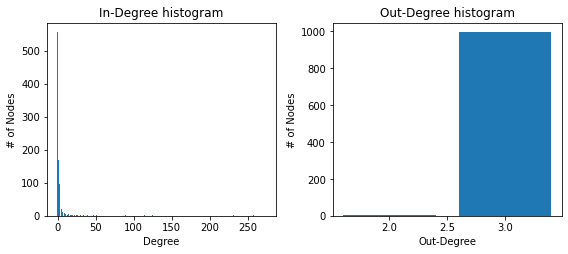

In [26]:
# In- and Out-Degree distribution

in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)

dmax = max(in_degree_sequence)


fig = plt.figure("In- and Out-Degree of our directed BA-graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(*np.unique(in_degree_sequence, return_counts=True))
ax1.set_title("In-Degree histogram")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Degree")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(out_degree_sequence, return_counts=True))
ax2.set_title("Out-Degree histogram")
ax2.set_xlabel("Out-Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [27]:
#F = nx.DiGraph()
#F.add_edges_from(([1, 2],[4, 5],[6,4],[2,4],[3,2],[5,1]),color='black')
#edges = F.edges()        
#colors = [F[u][v]['color'] for u,v in edges]
#nx.draw(F, with_labels=True, edge_color=colors)

In [28]:
#F_edgelist = nx.generate_edgelist(F)
#F_undir = nx.parse_edgelist(F_edgelist)
#nx.average_clustering(F_undir)

##### Adding triadic closure

In [29]:
G 
goalcoeff = .29
G_edgelist = nx.generate_edgelist(G)
G_undir = nx.parse_edgelist(G_edgelist)
clustercoeff = nx.average_clustering(G_undir)

while clustercoeff < goalcoeff:
    # 0 sample source node
    source = random.sample(G.nodes,1)[0]    
    
    # 1 sample 1 friend of source node
    if G.out_degree(source) > 1:  # only edges originating from these nodes: outgoing edges: befriending
        friend_of_source = random.sample([n for n in G.neighbors(source)],1)[0]
    else: 
        friend_of_source = [n for n in G.neighbors(source)][0]
    
    # 2 sample a friend of the friend, not source
    if G.out_degree(friend_of_source) > 1:
        friend_of_friend = random.sample([n for n in G.neighbors(friend_of_source)],1)[0]
    else: 
        friend_of_friend = [n for n in G.neighbors(friend_of_source)][0]
    
    # 3 add edge from the friend's friend to source node (if not source node chosen)
    if source != friend_of_friend:
        G.add_edge(source,friend_of_friend, color='r')
    
        G_edgelist = nx.generate_edgelist(G)
        G_undir = nx.parse_edgelist(G_edgelist)
        clustercoeff = nx.average_clustering(G_undir)


/var/folders/0h/1n_j20xj2zzg446ph069f1z00000gn/T/ipykernel_1445/453741616.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  source = random.sample(G.nodes,1)[0]


In [30]:
#edges = G.edges()        
#colors = [G[u][v]['color'] for u,v in edges]
#x.draw(G, with_labels=True, edge_color=colors)

In [31]:
nx.average_clustering(G_undir)

0.29002779991123523

In [32]:
sum([d for (n, d) in G.out_degree()]) / float(G.number_of_nodes())

3.582

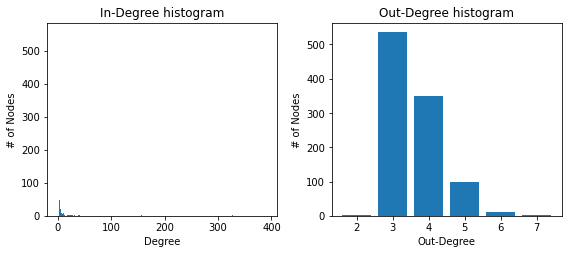

In [33]:
# In- and Out-Degree distribution

in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)

dmax = max(in_degree_sequence)


fig = plt.figure("In- and Out-Degree of our directed BA-graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(*np.unique(in_degree_sequence, return_counts=True))
ax1.set_title("In-Degree histogram")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Degree")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(out_degree_sequence, return_counts=True))
ax2.set_title("Out-Degree histogram")
ax2.set_xlabel("Out-Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [ ]:
nx.write_gml(G, "Amended_BA_Friction_m=3_n=1000_coeff=.29.gml")

In [34]:
Emp = nx.read_gml("/Users/laurajahn/Documents/Git/Follower network for marketplace/follower_network.gml", destringizer=int)

In [35]:
file = "/Users/laurajahn/Documents/Git/Follower network for marketplace/follower_network.gml"
def read_empirical_network(file):
    # print('File: ', file)
    net = ig.Graph.Read_GML(file)
    
    #prevent errors with duplicate attribs
    net = _delete_unused_attributes(net, desire_attribs=['label', 'party', 'misinfo'])
    return net 

def _delete_unused_attributes(net, desire_attribs=['uid','party', 'misinfo']):
    #delete unused attribs or artifact of igraph to maintain consistency
    for attrib in net.vs.attributes():
        if attrib not in desire_attribs:
            del(net.vs[attrib])
    return net 

In [36]:
Emp = read_empirical_network(file)

In [37]:
ig.summary(Emp)

IGRAPH D--- 10006 1809798 -- 
+ attr: label (v), misinfo (v), party (v)


In [38]:
max(Emp.degree())

3857

##### In- and Out Degree distribution

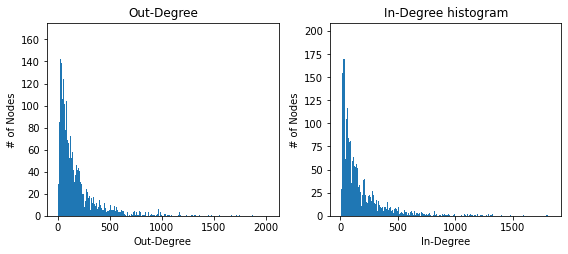

In [39]:
fig = plt.figure("In- and Out-Degree", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
bins = 1000
ax1.hist(Emp.outdegree(), bins)
ax1.set_title("Out-Degree")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Out-Degree")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.hist(Emp.indegree(), bins)
ax2.set_title("In-Degree histogram")
ax2.set_xlabel("In-Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

##### Average out/in degree

In [40]:
mean(Emp.outdegree())

180.8712772336598

In [41]:
# treat directed emp network as undirected to calculate avergae clustering coefficient
type(Emp)
Emp_nx_edgelist = Emp.get_edgelist()
Emp_nx = nx.Graph(Emp_nx_edgelist)

##### Transitivity

In [42]:
# NETWORKX PACKAGE
# print(nx.triangles(G))  # not implemented for directed type 
print(nx.transitivity(Emp_nx)) # Compute graph transitivity, the fraction of all possible triangles present in G. #Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

0.20350813879974466


In [43]:
# IGRAPH PACKAGE
# Transitivity (average clustering coeff) 
Emp.transitivity_undirected()

0.20350813879974466

##### Average clustering coefficient

In [44]:
# NETWORKX PACKAGE
format(nx.average_clustering(Emp_nx), 'f')

'0.293209'

#### Other: Triangles, ...

In [253]:
dimat = nx.to_numpy_matrix(G,dtype=int)
dimat = np.matrix.tolist(dimat)
print("The Number of triangles in directed graph : %d" % countTriangle(dimat, True))

The Number of triangles in directed graph : 39200


In [255]:
 print("Total number of triangles possible is",
          findNumberOfTriangles(dimat, len(dimat)))

Total number of triangles possible is 1216165


In [254]:

# Python3 code to count the number of
# possible triangles using brute
# force approach
 
# Function to count all possible
# triangles with arr[] elements
 
 
def findNumberOfTriangles(arr, n):
 
    # Count of triangles
    count = 0
 
    # The three loops select three
    # different values from array
    for i in range(n):
        for j in range(i + 1, n):
 
            # The innermost loop checks for
            # the triangle property
            for k in range(j + 1, n):
 
                # Sum of two sides is greater
                # than the third
                if (arr[i] + arr[j] > arr[k] and
                    arr[i] + arr[k] > arr[j] and
                        arr[k] + arr[j] > arr[i]):
                    count += 1
    return count
 
 
# Driver code
if __name__ == "__main__":
    arr = [10, 21, 22, 100, 101, 200, 300]
    size = len(arr)
 
    # Function call
    print("Total number of triangles possible is",
          findNumberOfTriangles(arr, size))

Total number of triangles possible is 6


In [152]:
# Python program to count triangles
# in a graph.  The program is
# for adjacency matrix
# representation of the graph.
 
 
# function to calculate the number
# of triangles in a simple
# directed/undirected graph.
# isDirected is true if the graph
# is directed, its false otherwise
def countTriangle(g, isDirected):
    nodes = len(g)
    count_Triangle = 0
     
    # Consider every possible
    # triplet of edges in graph
    for i in range(nodes):
        for j in range(nodes):
            for k in range(nodes):
                 
                # check the triplet
                # if it satisfies the condition
                if(i != j and i != k and j != k and g[i][j] and g[j][k] and g[k][i]):
                    count_Triangle += 1
     
    # If graph is directed , division is done by 3
    # else division by 6 is done
    if isDirected:
      return count_Triangle//3 
    else: return count_Triangle//6
 
 
# Create adjacency matrix of an undirected graph
graph = [[0, 1, 1, 0],
         [1, 0, 1, 1],
         [1, 1, 0, 1],
         [0, 1, 1, 0]]
# Create adjacency matrix of a directed graph
digraph = [[0, 0, 1, 0],
           [1, 0, 0, 1],
           [0, 1, 0, 0],
           [0, 0, 1, 0]]
 
print("The Number of triangles in undirected graph : %d" %
      countTriangle(graph, False))
 
print("The Number of triangles in directed graph : %d" %
      countTriangle(digraph, True))
 
# This code is contributed by Neelam Yadav

The Number of triangles in undirected graph : 2
The Number of triangles in directed graph : 2


##### Modification: Each node should have at least out_degree 1 (=populated feed)

Make sure every node receives information: 
Add outgoing edges (for incoming information) for nodes with out-degree 0: For those, choose a connected node (friend) 
and then one of their friends and draw an edge from the friend's friend to the original node, 
this way, producing triangles

A (follower) --> B (friend): A follows B, A is friends with B: A sees B's post in their feed, out-degree, incoming information
A (friend) <-- B (follower): In-degree, A is followed by B

"We assume that the follower network is directed, as in Twitter and Instagram. The direction of a link goes from the follower to the followed (friend) account, capturing attention; when a friend’s post is reshared by a follower, information spreads in the opposite direction."

Every node has out-edges: is reachable
Not every node has in-edges->not every node has followers --> do we want every node to have followers?
